In [1]:
import numpy as np
import pandas as pd
import pickle
import sys
from sklearn.model_selection import GroupShuffleSplit
sys.path.append(".")

def family_wise_train_test_splitting(
    gene_families: np.array, test_size=0.8, random_state=42
):
    """
    Split the data into training and testing sets, ensuring that the gene families are not split between the two sets.

    gene_families: The gene families
    test_size: The proportion of the data to be used as the test set
    random_state: The random state for the shuffle split
    ---

    returns: Training and test indices

    """

    X = np.zeros(shape=(len(gene_families), 1))
    Y = np.zeros(shape=(len(gene_families), 1))

    # Create the split
    gss = GroupShuffleSplit(n_splits=1, test_size=test_size, random_state=random_state)

    # Split the data
    train_index, test_index = next(gss.split(X, Y, groups=gene_families))

    # assert no family is present in both sets
    assert (
        len(
            set(gene_families[train_index]).intersection(set(gene_families[test_index]))
        )
        == 0
    )

    # Return the split data indices
    return train_index, test_index

with open("../../../Data/Processed/XY_formats/One_hot_encoded_up_down_multi_pytorch.pkl", "rb") as f:
    xy_dict = pickle.load(f)

print("Data loaded")
# load the gene names
gene_names = np.load("../../../Data/Processed/XY_formats/gene_names_one_hot.npy")
print("Gene names loaded")
gene_families = pd.read_csv("../../../Data/Processed/gene_families.csv", index_col=1)
X_sequence = np.array(
    [xy_dict[gene][0][0].T for gene in xy_dict]
).squeeze()  # [random_index]
X_treatment = np.array([xy_dict[gene][0][1] for gene in xy_dict])  # [random_index]
Y = np.array([xy_dict[gene][1] for gene in xy_dict])  # [random_index]

# Get family names per gene
# load gene families


# Map gene names to family names
# I cannot use a dictionary because the genes are repeated 5 times, eachper treatment
# I will use a list instead
family_names = []
for gene in gene_names:
    family_names.append(gene_families.loc[gene, "family_id"])

Data loaded
Gene names loaded


In [3]:
print("len of family names", len(family_names)/5)

len of family names 28749.0


In [2]:
# Function to compute label ratios (for binary classification, for example)

def compute_label_ratios(labels):
    unique, counts = np.unique(labels, return_counts=True)
    label_ratios = counts / len(labels)  # Calculate the ratio of each label
    return dict(zip(unique, label_ratios))

# Initialize lists to store label ratios for each set over different random seeds
train_label_ratios_list = []
val_label_ratios_list = []
test_label_ratios_list = []

# Calculate label ratios for the entire dataset
overall_label_ratios = compute_label_ratios(Y)
print(f"Overall label ratios in the dataset: {overall_label_ratios}")

# Loop over 10 random seeds and generate train/val/test splits
for i in range(1):
    random_seed = 12345 + i
    np.random.seed(random_seed)
    use_family_wise_split = True
    print(f"Using family-wise splitting: {use_family_wise_split}")
    
    if use_family_wise_split:
        # Family-wise splitting for train/test
        random_state = 1 + i
        train_index, test_index = family_wise_train_test_splitting(
            np.array(family_names), random_state=random_state, test_size=0.1
        )
        
        # Family-wise splitting for train/validation
        random_state = 2 + i
        train_index, val_index = family_wise_train_test_splitting(
            np.array(family_names)[train_index],
            random_state=random_state,
            test_size=0.23,
        )
        
        # Split the data into train, validation, and test sets
        X_train_sequence = X_sequence[train_index]
        X_test_sequence = X_sequence[test_index]
        X_train_treatment = X_treatment[train_index]
        X_test_treatment = X_treatment[test_index]
        Y_train = Y[train_index]
        Y_test = Y[test_index]
        X_val_sequence = X_sequence[val_index]
        X_val_treatment = X_treatment[val_index]
        Y_val = Y[val_index]

        # Calculate label ratios for train, val, and test sets
        train_label_ratios_list.append(compute_label_ratios(Y_train))
        val_label_ratios_list.append(compute_label_ratios(Y_val))
        test_label_ratios_list.append(compute_label_ratios(Y_test))

# Function to average label ratios across multiple random seed iterations
def average_label_ratios(label_ratios_list):
    avg_ratios = {}
    total_iterations = len(label_ratios_list)
    
    # Initialize a sum dictionary
    for label in label_ratios_list[0].keys():
        avg_ratios[label] = 0
    
    # Sum up the label ratios
    for label_ratios in label_ratios_list:
        for label, ratio in label_ratios.items():
            avg_ratios[label] += ratio
    
    # Divide by total iterations to get the average
    for label in avg_ratios:
        avg_ratios[label] /= total_iterations
    
    return avg_ratios

# Calculate the average label ratios for train, validation, and test sets
avg_train_label_ratios = average_label_ratios(train_label_ratios_list)
avg_val_label_ratios = average_label_ratios(val_label_ratios_list)
avg_test_label_ratios = average_label_ratios(test_label_ratios_list)

# Print the average label ratios
print(f"Average label ratios in the train set: {avg_train_label_ratios}")
print(f"Average label ratios in the validation set: {avg_val_label_ratios}")
print(f"Average label ratios in the test set: {avg_test_label_ratios}")


Overall label ratios in the dataset: {0: 0.1412083898570385, 1: 0.7337507391561445, 2: 0.12504087098681693}
Using family-wise splitting: True
Average label ratios in the train set: {0: 0.13587839871576202, 1: 0.7423898866258654, 2: 0.12173171465837263}
Average label ratios in the validation set: {0: 0.13629472942005993, 1: 0.7410893707033316, 2: 0.1226158998766085}
Average label ratios in the test set: {0: 0.14029280712921705, 1: 0.7309357097390198, 2: 0.1287714831317632}


In [17]:
# Function to compute the percentage of overlap between two index arrays
def compute_overlap_percentage(indices1, indices2):
    overlap = np.intersect1d(indices1, indices2)
    return len(overlap) / len(indices1) * 100  # Percentage of overlap
def compute_avg_overlap(indices_list):
    total_overlap_percentage = 0
    comparisons = 0
    
    # Compare each pair of index sets
    for i in range(len(indices_list)):
        for j in range(i+1, len(indices_list)):
            overlap_percentage = compute_overlap_percentage(sorted(indices_list[i]), sorted(indices_list[j]))
            #print(f"Overlap between set {i} and set {j}: {overlap_percentage:.2f}%")
            total_overlap_percentage += overlap_percentage
            comparisons += 1
    
    # Return average overlap percentage
    return total_overlap_percentage / comparisons
# Function to compute the average overlap percentage across all seeds
def compute_family_set_overlap_percentage(set_list):
    total_overlap_percentage = 0
    comparisons = 0
    for i in range(len(set_list)):
        for j in range(i+1,len(set_list)):
            set1 = set_list[i]
            set2 = set_list[j]
        
            overlap = set1.intersection(set2)
            total_overlap_percentage += len(overlap) / len(set1) * 100
            comparisons += 1
    return total_overlap_percentage / comparisons
# Initialize lists to store indices for each seed
train_indices_list = []
train_family_set_list = []
val_indices_list = []
val_family_set_list = []
test_indices_list = []
test_family_set_list = []

for use_family_wise_split in [True,False]:
    train_indices_list = []
    train_family_set_list = []
    val_indices_list = []
    val_family_set_list = []
    test_indices_list = []
    test_family_set_list = []
    print(f"Use family wise split: {use_family_wise_split}")
    # Loop over 10 random seeds and generate train/val/test splits
    for i in range(10):
        random_seed = 12345 + i
        np.random.seed(random_seed)
        
        if use_family_wise_split:
            # Family-wise splitting for train/test
            random_state = 1 + i
            train_index, test_index = family_wise_train_test_splitting(
                np.array(family_names), random_state=random_state, test_size=0.1
            )
            
            # Family-wise splitting for train/validation
            random_state = 2 + i
            train_index, val_index = family_wise_train_test_splitting(
                np.array(family_names)[train_index],
                random_state=random_state,
                test_size=0.23,
            )
        else:
            # Random splitting (disregarding protein families)
            from sklearn.model_selection import train_test_split

            # Perform random splitting for train/test sets
            indices = np.arange(len(family_names))
            random_state = 1 + i
            train_index, test_index = train_test_split(
                indices, test_size=0.1, random_state=random_state
            )

            # Perform random splitting for validation set
            random_state = 2 + i
            train_index, val_index = train_test_split(
                train_index, test_size=0.23, random_state=random_state
            )
        # Store the indices
        train_indices_list.append(train_index)
        train_family_set_list.append(set(np.array(family_names)[train_index]))
        val_indices_list.append(val_index)
        val_family_set_list.append(set(np.array(family_names)[val_index]))
        test_indices_list.append(test_index)
        test_family_set_list.append(set(np.array(family_names)[test_index]))
        print(f"Unique families in test set: {len(set(np.array(family_names)[test_index]))}")
        print(f"families in test set: {sorted(set(np.array(family_names)[test_index]))}")
        print(f"Number of genes in test set: {len(test_index)}")


    # Compute the overlap percentages between train, val, and test family sets
    train_overlapp = compute_family_set_overlap_percentage(train_family_set_list)
    val_overlap = compute_family_set_overlap_percentage(val_family_set_list)
    test_overlap = compute_family_set_overlap_percentage(test_family_set_list)

    print(f"Train Family Set Overlap: {train_overlapp:.2f}%")
    print(f"Validation Family Set Overlap: {val_overlap:.2f}%")
    print(f"Test Family Set Overlap: {test_overlap:.2f}%")



    # Calculate the average overlap percentages
    avg_train_overlap = compute_avg_overlap(train_indices_list)
    avg_val_overlap = compute_avg_overlap(val_indices_list)
    avg_test_overlap = compute_avg_overlap(test_indices_list)

    # Print the results
    print(f"Average Train Indices Overlap: {avg_train_overlap:.2f}%")
    print(f"Average Validation Indices Overlap: {avg_val_overlap:.2f}%")
    print(f"Average Test Indices Overlap: {avg_test_overlap:.2f}%")
    print("_"*50)


Use family wise split: True
Unique families in test set: 990
families in test set: [6, 7, 28, 32, 40, 43, 45, 67, 79, 82, 98, 99, 106, 108, 112, 128, 130, 136, 146, 147, 159, 161, 209, 215, 218, 220, 222, 229, 234, 254, 259, 260, 274, 278, 286, 288, 307, 308, 324, 337, 342, 372, 391, 394, 397, 408, 420, 428, 437, 457, 473, 481, 509, 527, 551, 553, 575, 576, 583, 588, 590, 595, 598, 601, 617, 620, 626, 628, 645, 660, 663, 677, 686, 690, 692, 696, 713, 726, 729, 737, 764, 782, 805, 807, 821, 826, 831, 835, 859, 860, 877, 882, 892, 896, 912, 914, 922, 924, 940, 942, 955, 957, 962, 976, 977, 989, 995, 1006, 1012, 1039, 1050, 1061, 1071, 1074, 1079, 1086, 1092, 1095, 1105, 1115, 1123, 1142, 1160, 1164, 1168, 1171, 1173, 1178, 1186, 1187, 1207, 1218, 1226, 1234, 1263, 1265, 1289, 1290, 1294, 1301, 1313, 1316, 1322, 1339, 1359, 1397, 1411, 1425, 1434, 1438, 1459, 1464, 1509, 1511, 1516, 1523, 1538, 1541, 1545, 1546, 1547, 1556, 1573, 1577, 1584, 1609, 1616, 1629, 1634, 1653, 1686, 1719, 1721,

In [25]:
from matplotlib import pyplot as plt
gene_names

array(['AT1G01010', 'AT1G01020', 'AT1G01030', ..., 'ATMG01380',
       'ATMG01390', 'ATMG01400'], dtype='<U9')

Number of unique families: 9892
Minimum number of datapoints in a family: 5
Maximum number of datapoints in a family: 4340
Average number of datapoints in a family: 14.531439547108775
Median number of datapoints in a family: 5.0


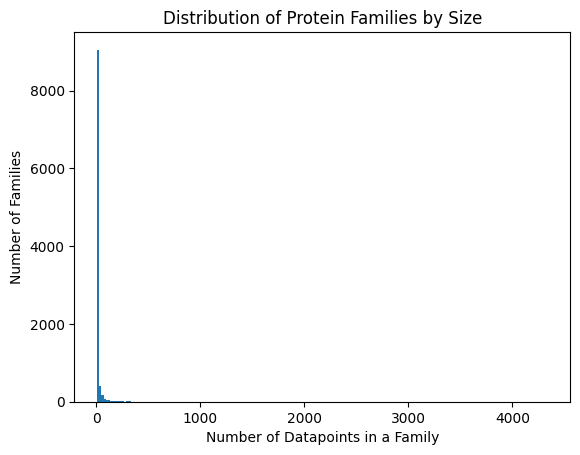

In [36]:
# Count the occurrences of each family name (treating them as unique identifiers)
family_name_counts = np.unique(family_names, return_counts=True)[1]
family_id_to_count_map = dict(zip(np.unique(family_names), family_name_counts))

print(f"Number of unique families: {len(family_name_counts)}")
print(f"Minimum number of datapoints in a family: {family_name_counts.min()}")
print(f"Maximum number of datapoints in a family: {family_name_counts.max()}")
print(f"Average number of datapoints in a family: {family_name_counts.mean()}")
print(f"Median number of datapoints in a family: {np.median(family_name_counts)}")
sorted(family_name_counts)[::-1]
# Create the histogram
plt.hist(family_name_counts,bins=200)
plt.xlabel("Number of Datapoints in a Family")
plt.ylabel("Number of Families")
plt.title("Distribution of Protein Families by Size")
plt.show()

In [37]:
family_id_to_count_map

{0: 45,
 1: 45,
 2: 135,
 3: 840,
 4: 35,
 5: 5,
 6: 5,
 7: 45,
 8: 820,
 9: 310,
 10: 305,
 11: 40,
 12: 135,
 13: 495,
 14: 60,
 15: 10,
 16: 5,
 17: 145,
 18: 295,
 19: 15,
 20: 15,
 21: 30,
 22: 5,
 23: 5,
 24: 40,
 25: 85,
 26: 170,
 27: 20,
 28: 195,
 29: 1045,
 30: 1320,
 31: 1390,
 32: 1130,
 33: 80,
 34: 755,
 35: 25,
 36: 150,
 37: 20,
 38: 50,
 39: 80,
 40: 595,
 41: 40,
 42: 5,
 43: 225,
 44: 35,
 45: 75,
 46: 445,
 47: 65,
 48: 320,
 49: 135,
 50: 135,
 51: 35,
 52: 25,
 53: 95,
 54: 210,
 55: 270,
 56: 145,
 57: 25,
 58: 120,
 59: 235,
 60: 55,
 61: 65,
 62: 90,
 63: 215,
 64: 90,
 65: 410,
 66: 4340,
 67: 390,
 68: 110,
 69: 15,
 70: 235,
 71: 90,
 72: 175,
 73: 30,
 74: 15,
 75: 205,
 76: 45,
 77: 610,
 78: 5,
 79: 5,
 80: 20,
 81: 150,
 82: 105,
 83: 155,
 84: 105,
 85: 20,
 86: 175,
 87: 5,
 88: 5,
 89: 20,
 90: 300,
 91: 955,
 92: 85,
 93: 10,
 94: 5,
 95: 50,
 96: 295,
 97: 960,
 98: 5,
 99: 35,
 100: 320,
 101: 305,
 102: 105,
 103: 540,
 104: 100,
 105: 25,
 106: 

In [27]:
gene_families

,family_id
gene_id,
AT1G50920,0
AT1G10300,0
AT1G80770,0
AT3G23860,0
AT1G78010,0
...,...
AT3G29153,19788
AT2G21310,19789
AT5G35923,19790


In [ ]:
print(f"Starting iteration {i}")
random_seed = 12345 + i
np.random.seed(random_seed)
# Select randomly 30000 instances index
# random_index = np.random.choice(range(len(gene_names)), 3000, replace=False)

X_sequence = np.array(
    [xy_dict[gene][0][0].T for gene in xy_dict]
).squeeze()  # [random_index]
X_treatment = np.array([xy_dict[gene][0][1] for gene in xy_dict])  # [random_index]
Y = np.array([xy_dict[gene][1] for gene in xy_dict])  # [random_index]

# Get family names per gene
# load gene families


# Map gene names to family names
# I cannot use a dictionary because the genes are repeated 5 times, eachper treatment
# I will use a list instead
family_names = []
for gene in gene_names:
    family_names.append(gene_families.loc[gene, "family_id"])


# Split the data
use_family_wise_split = True  # Set this to False for random splitting
print(f"Using family-wise splitting: {use_family_wise_split}")
if use_family_wise_split:
    # Family-wise splitting
    random_state = 1 + i
    train_index,test_index  = family_wise_train_test_splitting(
        np.array(family_names), random_state=random_state, test_size=0.1
    )
    
    # Get validation set from train set
    random_state = 2 + i
    train_index, val_index = family_wise_train_test_splitting(
        np.array(family_names)[train_index],
        random_state=random_state,
        test_size=0.23,
    )
else:
    # Random splitting (disregarding protein families)
    from sklearn.model_selection import train_test_split

    # Perform random splitting for train/test sets
    indices = np.arange(len(family_names))
    random_state = 1 + i
    train_index, test_index = train_test_split(
        indices, test_size=0.2, random_state=random_state
    )

    # Perform random splitting for validation set
    random_state = 2 + i
    train_index, val_index = train_test_split(
        train_index, test_size=0.3, random_state=random_state
    )

# X_sequence = torch.tensor(X_sequence, dtype=torch.default_dtype)
# X_treatment = torch.tensor(X_treatment, dtype=torch.default_dtype)
# Y = torch.tensor(Y, dtype=torch.long)
X_train_sequence = X_sequence[train_index]
X_test_sequence = X_sequence[test_index]
X_train_treatment = X_treatment[train_index]
X_test_treatment = X_treatment[test_index]
Y_train = Y[train_index]
Y_test = Y[test_index]
X_val_sequence = X_sequence[val_index]
X_val_treatment = X_treatment[val_index]
Y_val = Y[val_index]